# LAB 2,3: NN2: Implementation of backpropagation.

In this lab, you need to implement error back propagation learning of a neural network. To test the implementation, perform the learning on simple learning data provided in class. Then implement a method to visualize the values of the network weights in successive iterations and, in case the network fails to learn, try to use these visualizations to determine the cause of the problem. Implement a version with the weights updated after the presentation of all patterns and a version with the weights updated after the presentation of successive portions (batch). Compare the learning rate for each variant.


Initialize the weights from a uniform distribution on the interval [0,1]. Optionally implement another method for initializing weights. Either the He or Xavier method.


Test the learning of the network on the following sets (MSE value in parentheses to get 4 points):
* square-simple (if the network is not able to learn this function then something is very badly done, MSE: 4),
* steps-small (MSE: 4),
* multimodal-large (MSE: 40).

(MSE values calculated on unnormalized data).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.special import expit
from numpy.random import permutation
from sklearn import preprocessing
import itertools
import matplotlib.pyplot as plt
import networkx as nx
np.random.seed(777)

# MLP

In [3]:
def sigmoid(x): 
    return expit(x)

def linear(x):
    return x

def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))

def linear_prime(z):
    return z

In [4]:
def generate_weights_and_biases(layers, init_method):
    weights = []
    biases = []
    if init_method == 'uniform':
        for i in range(1, len(layers)):
            np.random.seed(777)
            weights.append(np.random.uniform(low=0.0, high=1.0, size=(layers[i-1], layers[i])))
            biases.append(np.zeros((1, layers[i])))
    elif init_method == 'Xavier':
        for i in range(1, len(layers)):
            np.random.seed(123)
            weights.append(np.random.randn(layers[i-1], layers[i]) * np.sqrt(1/layers[i-1]))
            biases.append(np.random.randn(1, layers[i])*np.sqrt(1/(layers[i-1])))
    elif init_method == 'He':
        for i in range(1, len(layers)):
            np.random.seed(777)
            weights.append(np.random.randn(layers[i-1], layers[i]) * np.sqrt(2/layers[i-1]))
            biases.append(np.random.randn(1, layers[i])*np.sqrt(2/(layers[i-1])))
                          
    return weights, biases

In [5]:
def feedforward(x, weights, biases, layers):   
    # activations is a list of activations for each layer, starting with the input layer and ending with the output layer.
    # on the first rotation is x without the activation function, which is the input data
    activations = [x]
    zs = [] # zs is a list of values (weighted sums plus biases) for each layer, starting with the hidden layer and ending with the output layer
    for j in range(len(layers)-2):
        z = np.dot(activations[-1], weights[j]) + biases[j]
        zs.append(z)
        activation = sigmoid(z)    # for hidden layers, the activation function is sigmoid
        activations.append(activation)
        
    z = np.dot(activations[-1], weights[-1]) + biases[-1]
    zs.append(z)
    activation = linear(z) # for the last layer there is a linear activation function
    activations.append(activation)
    return activations, zs

In [6]:
def calculate_loss(y, activations, losses):
    loss = mean_squared_error(y, activations[-1])
    losses.append(loss)
    return losses

In [7]:
def backpropagation(y, activations, weights, biases, zs):
    deltas = [None] * len(weights)
    deltas[-1] = activations[-1] - y
    for i in reversed(range(len(deltas) - 1)):
        deltas[i] = (np.dot(weights[i + 1], deltas[i + 1].T) * sigmoid_prime(zs[i]).T).T

    biases_prime = [None] * len(deltas)
    weights_prime = [None] * len(deltas)
    y_size = y.shape[0]
    for i in range(len(deltas)):
        weights_prime[i] = np.dot(deltas[i].T, activations[i]).T / y_size
        biases_prime[i] = np.dot(deltas[i].T, np.ones((y_size, 1))).T / y_size
        
    return weights_prime, biases_prime

In [8]:
def update_weights_biases(weights, biases, learning_rate, weights_prime, biases_prime):

    for i in range(len(weights)):
        weights[i] -= learning_rate * weights_prime[i]
        biases[i] -= learning_rate * biases_prime[i]

    return weights, biases

In [9]:
def train_sgd(x, y, layers, epochs, learning_rate, init_method):

    weights, biases = generate_weights_and_biases(layers, init_method)
    losses = []  
    
    for epoch in range(epochs):  
        activations, zs = feedforward(x, weights, biases, layers)
        losses = calculate_loss(y, activations, losses)
        weights_prime, biases_prime = backpropagation(y, activations, weights, biases, zs)
        weights, biases = update_weights_biases(weights, biases, learning_rate, weights_prime, biases_prime)
#         if epoch % 500 == 0:
#             activations_test, zs_test = feedforward(x_test, weights, biases, layers)
#             print("Epoch {}: Loss train: {} Loss test: {}".format(epoch, losses[-1], mean_squared_error(y_test, activations_test[-1])))
        
    return weights, biases, losses

In [10]:
def train_mini_batch_gradient_decent(x, y, layers, epochs, learning_rate, batch_size, init_method):
    
    weights, biases = generate_weights_and_biases(layers, init_method)
    losses = []  
    
    for epoch in range(epochs): 
        perm = np.random.permutation(len(y))
        x = x.iloc[perm]
        y = y.iloc[perm]
        
        i = 0
        while i < len(y): # loop to create batches and train on them
            x_batch = x[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            i = i + batch_size
            activations_batch, zs = feedforward(x_batch, weights, biases, layers)
            weights_prime, biases_prime = backpropagation(y_batch, activations_batch, weights, biases, zs)
            weights, biases = update_weights_biases(weights, biases, learning_rate, weights_prime, biases_prime)
            #print("Batch-loss in batch {} = {}".format(i, mean_squared_error(y_batch, activations_batch[-1])))
            
        # after each epoch print what now loss on the entire set
        activations, zs = feedforward(x, weights, biases, layers)
        losses = calculate_loss(y, activations, losses)
#         if epoch % 10 == 0:
#             activations_test, zs_test = feedforward(x_test, weights, biases, layers)
#             print("Epoch {}: Loss train: {} Loss test: {}".format(epoch, losses[-1], mean_squared_error(y_test, activations_test[-1])))
         
    return weights, biases, losses

In [11]:
def mlp_mini_batch_GD(x, y, x_test, y_test, layers, epochs, learning_rate, batch_size, init_method):
    weights, biases, losses = train_mini_batch_gradient_decent(x, y, layers, epochs, learning_rate, batch_size, init_method)
    activations, zs = feedforward(x, weights, biases, layers)
    predictions = activations[-1]
    
    activations_test, zs = feedforward(x_test, weights, biases, layers)
    predictions_test = activations_test[-1]
    print("MSE na zbiorze testowym:", mean_squared_error(y_test, predictions_test))
    
    plt.subplots(1, 2, figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(x, y, color='green')
    plt.scatter(x, predictions, color='red')
    plt.title("Zbiór treningowy")
    plt.subplot(1, 2, 2)
    plt.scatter(x_test, y_test, color='green')
    plt.scatter(x_test, predictions_test, color='red')
    plt.title("Zbiór testowy")
    plt.show()
    return losses

In [12]:
def mlp_SGD(x, y, x_test, y_test, layers, epochs, learning_rate, init_method):
    weights, biases, losses = train_sgd(x, y, layers, epochs, learning_rate, init_method)
    activations, zs = feedforward(x, weights, biases, layers)
    predictions = activations[-1]
    
    activations_test, zs = feedforward(x_test, weights, biases, layers)
    predictions_test = activations_test[-1]
    print("MSE na zbiorze testowym:", mean_squared_error(y_test, predictions_test))
    
    plt.subplots(1, 2, figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(x, y, color='green')
    plt.scatter(x, predictions, color='red')
    plt.title("Zbiór treningowy")
    plt.subplot(1, 2, 2)
    plt.scatter(x_test, y_test, color='green')
    plt.scatter(x_test, predictions_test, color='red')
    plt.title("Zbiór testowy")
    plt.show()
    return losses

## square-simple

In [13]:
data_train = pd.read_csv('../data/regression/square-simple-training.csv', index_col = 0)
data_test = pd.read_csv('../data/regression/square-simple-test.csv', index_col = 0)
x = data_train[['x']]
y = data_train[['y']]
x_test = data_test[['x']]
y_test = data_test[['y']]

MSE na zbiorze testowym: 3.977021885891326


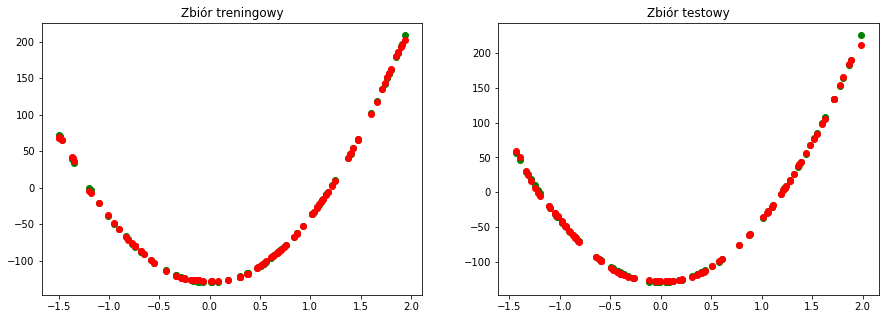

In [14]:
losses = mlp_SGD(x, y, x_test, y_test, layers=[1, 17, 1], epochs=35000, learning_rate=0.002, init_method='uniform')

MSE na zbiorze testowym: 3.335570073704885


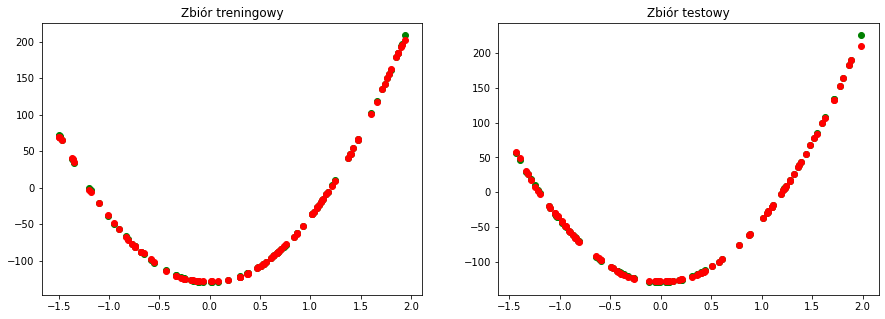

In [15]:
losses = mlp_mini_batch_GD(x, y, x_test, y_test, layers=[1, 17, 1], epochs=5000, learning_rate=0.003, batch_size=20, init_method='Xavier')

MSE na zbiorze testowym: 3.977021885891326


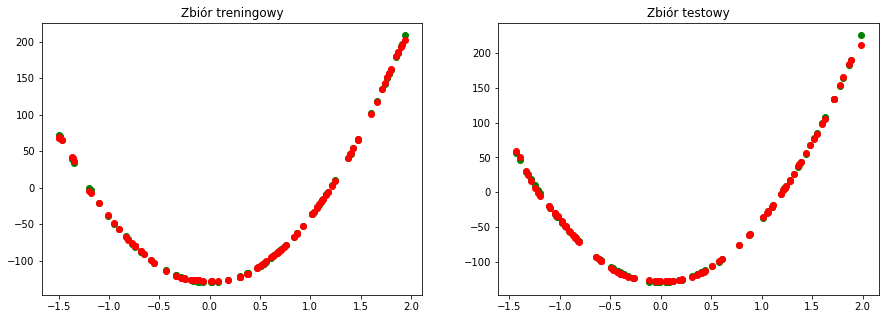

In [16]:
losses = mlp_SGD(x, y, x_test, y_test, layers=[1, 17, 1], epochs=35000, learning_rate=0.002, init_method='uniform')

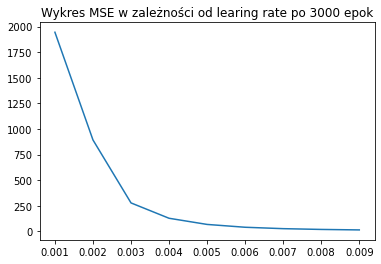

In [19]:
losses_list = []
lr_list = np.arange(0.001, 0.01, 0.001)
for lr in lr_list:
    weights, biases, losses = train_sgd(x, y, layers= [1, 17, 1], epochs=3000, learning_rate=lr, init_method='uniform')
    losses_list.append(losses[-1])

plt.plot(lr_list, losses_list)
plt.title("Wykres MSE w zależności od learing rate po 3000 epok")
plt.show()

## steps small

In [36]:
data_train = pd.read_csv('../data/regression/steps-small-training.csv', index_col = 0)
data_test = pd.read_csv('../data/regression/steps-small-test.csv', index_col = 0)
x = data_train[['x']]
y = data_train[['y']]
x_test = data_test[['x']]
y_test = data_test[['y']]

MSE na zbiorze testowym: 99.87786207525319


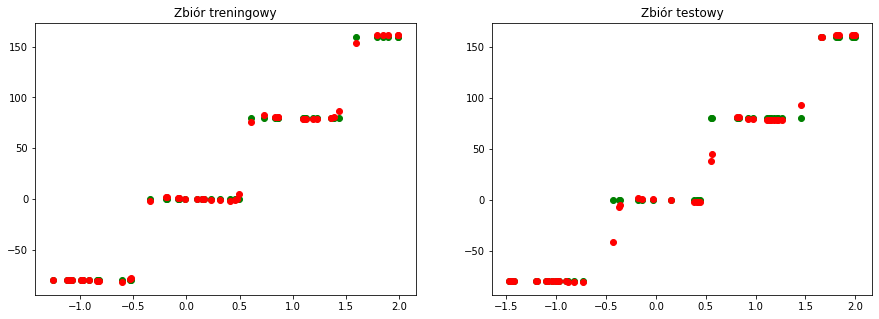

In [37]:
losses = mlp_mini_batch_GD(x, y, x_test, y_test, layers=[1, 20, 1], epochs=50000, learning_rate=0.003, batch_size=20, init_method='Xavier')

MSE na zbiorze testowym: 97.37128583891601


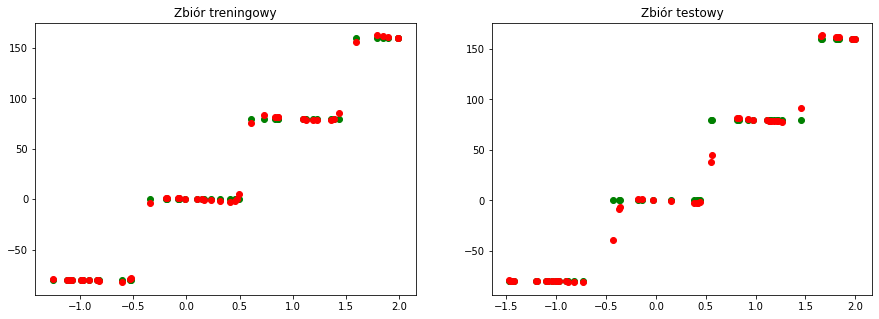

In [38]:
losses = mlp_mini_batch_GD(x, y, x_test, y_test, layers=[1, 25, 1], epochs=10000, learning_rate=0.01, batch_size=10, init_method='He')

MSE na zbiorze testowym: 138.36026076813755


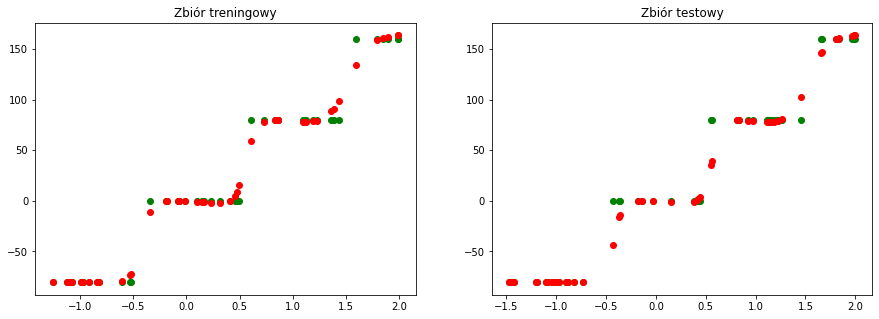

In [39]:
losses = mlp_SGD(x, y, x_test, y_test, layers=[1, 30, 1], epochs=35000, learning_rate=0.002, init_method='uniform')

## multimodal large

In [40]:
data_train = pd.read_csv('../data/regression/multimodal-large-training.csv')
data_test = pd.read_csv('../data/regression/multimodal-large-test.csv')
x = data_train[['x']]
y = data_train[['y']]
x_test = data_test[['x']]
y_test = data_test[['y']]

MSE na zbiorze testowym: 3.588399312504193


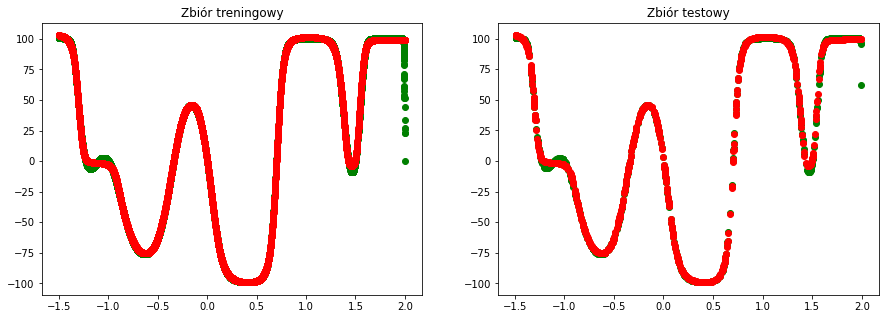

In [42]:
losses = mlp_mini_batch_GD(x, y, x_test, y_test, layers=[1, 16, 66, 1], epochs=100, learning_rate=0.01, batch_size=100, init_method='He')

MSE na zbiorze testowym: 3.634922478438015


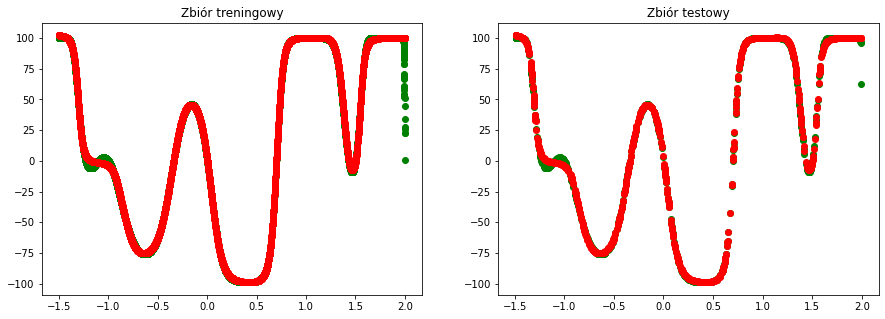

In [43]:
losses = mlp_mini_batch_GD(x, y, x_test, y_test, layers=[1, 7, 77, 1], epochs=100, learning_rate=0.01, batch_size=50, init_method='He')

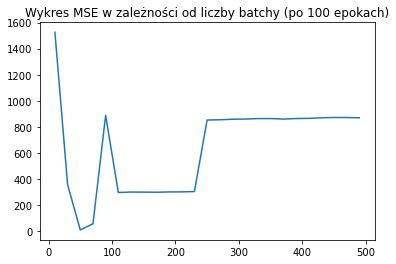

In [32]:
losses_ = []
batches_ = np.arange(10, 500, 20)
for batch in batches_:
    weights, biases, losses = train_mini_batch_gradient_decent(x, y, layers=[1, 7, 77, 1], epochs=100, learning_rate=0.01, batch_size=batch, init_method='He')
    losses_.append(losses[-1])

plt.plot(batches_, losses_)
plt.title("Wykres MSE w zależności od liczby batchy (po 100 epokach)")
plt.show()

## Visualization

Visualizations of weights were used in a working way to preview how it changes with different parameters, in the end, however, networks are quite large so I will only present an example of how such a visualization of the network would look like

In [29]:
def visualise(layers, biases, weights):
    biases.insert(0, np.array([[0]]))
    weights = np.concatenate([w.ravel() for w in weights]).tolist()

    def multilayered_graph(*layers):
        extents = nx.utils.pairwise(itertools.accumulate((0,) + layers))
        layers = [range(start, end) for start, end in extents]
        G = nx.Graph()
        for (i, layer) in enumerate(layers):
            G.add_nodes_from(layer, layer=i)
        for layer1, layer2 in nx.utils.pairwise(layers):
            G.add_edges_from(itertools.product(layer1, layer2))
        return G


    G = multilayered_graph(*layers)
    pos = nx.multipartite_layout(G, subset_key="layer")
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, node_color='pink', with_labels=False, node_size=2000)
    labels = {}    
    for node in G.nodes():
        labels[node] = round(np.concatenate([b.ravel() for b in biases]).tolist()[node], 2)
    nx.draw_networkx_labels(G, pos, labels, font_size=16, font_color='b')

    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels)
    edge_labels = {(u[0], u[1]): round(weights[i], 2) for u, i in zip(G.edges(data="layer"), range(len(weights)))}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, label_pos=0.5)
    plt.show()

#### Network visualization for the first dataset and architecture [1, 5, 5, 1]

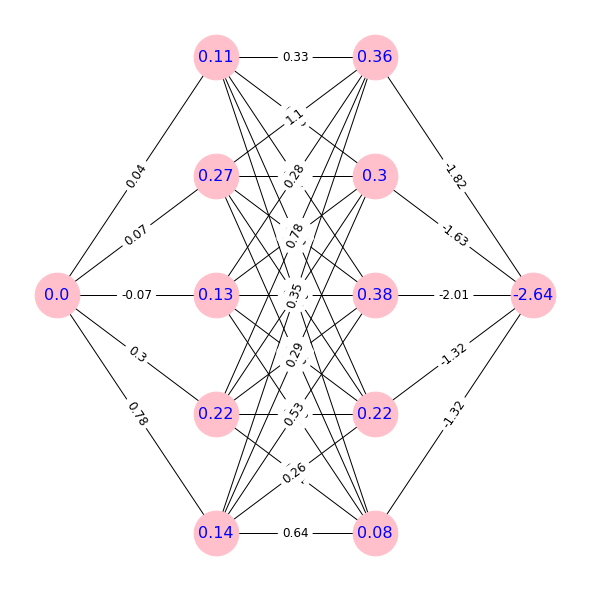

In [33]:
data_train = pd.read_csv('../../data/regression/square-simple-training.csv', index_col = 0)
data_test = pd.read_csv('../../data/regression/square-simple-test.csv', index_col = 0)
x = data_train[['x']]
y = data_train[['y']]

layers = [1, 5, 5, 1]
weights, biases, losses = train_sgd(x, y, layers, epochs=100, learning_rate=0.001, init_method='uniform')
visualise(layers, biases, weights)